# Notebook 1: Vision Transformer vs CNN Comparison Experiment

## 🎯 Experiment Objectives
Compare and analyze the performance differences between Vision Transformer and CNN in image forgery detection tasks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Custom Vision Transformer Implementation

Custom SimpleViT that works with 224x224 input images.

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=384):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, n_patches_h, n_patches_w)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, n_heads=6, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = torch.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads=6, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        attn_out = self.attn(self.norm1(x))
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x

class SimpleViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=2,
                 embed_dim=384, depth=6, n_heads=6, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        logits = self.head(cls_token_final)
        return logits

print("Custom SimpleViT model created successfully")
print(f"Expected input size: 224x224")
print(f"Patch size: 16x16")
print(f"Number of patches: {(224//16)**2} = {(224//16)**2}")

Custom SimpleViT model created successfully
Expected input size: 224x224
Patch size: 16x16
Number of patches: 196 = 196


## Data Loading with Balanced Sampling

In [3]:
def load_balanced_data(data_dir="CASIA2"):
    """
    Load balanced dataset to fix class imbalance issue
    Original problem: 78% real vs 22% fake images causing static 78% accuracy
    """
    auth_dir = os.path.join(data_dir, "Au")
    tp_dir = os.path.join(data_dir, "Tp")
    
    # Get all image paths
    auth_paths = glob(os.path.join(auth_dir, "*.jpg")) + glob(os.path.join(auth_dir, "*.png"))
    tamper_paths = glob(os.path.join(tp_dir, "*.jpg")) + glob(os.path.join(tp_dir, "*.png"))
    
    print(f"Found {len(auth_paths)} authentic images")
    print(f"Found {len(tamper_paths)} tampered images")
    
    # Balance the dataset by taking minimum of both classes
    min_samples = min(len(auth_paths), len(tamper_paths))
    balanced_auth = auth_paths[:min_samples]
    balanced_tamper = tamper_paths[:min_samples]
    
    print(f"Using {min_samples} samples from each class for balanced training")
    
    # Combine and create labels (0=authentic, 1=tampered)
    image_paths = balanced_auth + balanced_tamper
    labels = [0] * min_samples + [1] * min_samples
    
    return image_paths, labels

# Load balanced data
image_paths, labels = load_balanced_data()
print(f"Total balanced dataset size: {len(image_paths)}")
print(f"Class distribution: {np.bincount(labels)}")

Found 7437 authentic images
Found 2064 tampered images
Using 2064 samples from each class for balanced training
Total balanced dataset size: 4128
Class distribution: [2064 2064]


## Custom Dataset with Proper Preprocessing

In [4]:
class ForgeryDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_size = target_size
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load and preprocess image
        image = cv2.imread(img_path)
        if image is None:
            # Handle corrupted images
            image = np.random.randint(0, 255, (*self.target_size, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.target_size)
        
        # Convert to PIL for transforms
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Add rotation augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1)  # Random erasing for robustness
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms created successfully")
print(f"Training transforms include: RandomHorizontalFlip, RandomRotation, ColorJitter, RandomErasing")
print(f"Validation transforms: basic preprocessing only")

Data transforms created successfully
Training transforms include: RandomHorizontalFlip, RandomRotation, ColorJitter, RandomErasing
Validation transforms: basic preprocessing only


## Improved CNN Model

Enhanced CNN architecture with better regularization.

In [5]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(ImprovedCNN, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("Improved CNN model created successfully")
print(f"Expected input size: 224x224")
print(f"Architecture: 4 convolutional blocks + adaptive pooling + 3 FC layers")
print(f"Regularization: BatchNorm + Dropout (p=0.3)")

Improved CNN model created successfully
Expected input size: 224x224
Architecture: 4 convolutional blocks + adaptive pooling + 3 FC layers
Regularization: BatchNorm + Dropout (p=0.3)


## Training Functions with Early Stopping

Implemented early stopping to prevent overfitting and ensure optimal model selection.

In [6]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(dataloader), 100. * correct / total

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(dataloader), 100. * correct / total

print("Training functions created successfully")
print(f"Early stopping patience: 7 epochs")
print(f"Min delta for improvement: 0.001")

Training functions created successfully
Early stopping patience: 7 epochs
Min delta for improvement: 0.001


## Comprehensive Evaluation Function

Multiple metrics for robust assessment including ROC-AUC and balanced accuracy.

In [7]:
def comprehensive_evaluation(model, dataloader, device, model_name="Model"):
    """Comprehensive evaluation with multiple metrics"""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    auc = roc_auc_score(all_labels, all_probs)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Authentic', 'Tampered'])
    
    print(f"=== {model_name} RESULTS ===")
    print(f"Validation AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Classification Report:")
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Confusion Matrix:")
    print(cm)
    
    return all_labels, all_preds, all_probs

print("Comprehensive evaluation function created")
print(f"Metrics: AUC, Balanced Accuracy, Classification Report, Confusion Matrix")

Comprehensive evaluation function created
Metrics: AUC, Balanced Accuracy, Classification Report, Confusion Matrix


## Data Preparation with Stratified Split

Using stratified split to maintain class balance in training and validation sets.

In [8]:
# Stratified train/validation split to maintain balance
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")

# Create datasets
train_dataset = ForgeryDataset(X_train, y_train, transform=train_transform)
val_dataset = ForgeryDataset(X_val, y_val, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

print("Data loaders created successfully")
print(f"Batch size: 16")
print(f"Workers: 4")

Training set: 3302 samples
Validation set: 826 samples
Training class distribution: [1651 1651]
Validation class distribution: [413 413]
Data loaders created successfully
Batch size: 16
Workers: 4


## Train CNN Model

Training improved CNN model with balanced data and early stopping.

In [ ]:
print("Training improved CNN model...")
cnn_model = ImprovedCNN(num_classes=2, dropout_rate=0.3).to(device)

criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
cnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='min', patience=5, factor=0.5)

cnn_train_losses, cnn_train_accs = [], []
cnn_val_losses, cnn_val_accs = [], []

early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(50):
    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, cnn_optimizer, device)
    val_loss, val_acc = validate_epoch(cnn_model, val_loader, criterion, device)
    
    cnn_train_losses.append(train_loss)
    cnn_train_accs.append(train_acc)
    cnn_val_losses.append(val_loss)
    cnn_val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    cnn_scheduler.step(val_loss)
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print("CNN training completed!")
torch.save(cnn_model.state_dict(), 'cnn.pth')

Training improved CNN model...


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.76it/s]


Epoch 1: Train Loss: 0.6789, Train Acc: 59.48%, Val Loss: 0.6422, Val Acc: 63.68%


Validation: 100%|██████████| 52/52 [00:01<00:00, 37.78it/s]


Epoch 2: Train Loss: 0.6671, Train Acc: 60.90%, Val Loss: 0.6507, Val Acc: 61.38%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.72it/s]


Epoch 3: Train Loss: 0.6486, Train Acc: 63.57%, Val Loss: 0.6574, Val Acc: 63.56%


Validation: 100%|██████████| 52/52 [00:01<00:00, 34.65it/s]


Epoch 4: Train Loss: 0.6316, Train Acc: 64.66%, Val Loss: 0.6240, Val Acc: 62.71%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.21it/s]


Epoch 5: Train Loss: 0.6322, Train Acc: 64.66%, Val Loss: 0.6080, Val Acc: 65.25%


Validation: 100%|██████████| 52/52 [00:01<00:00, 37.03it/s]


Epoch 6: Train Loss: 0.6237, Train Acc: 65.57%, Val Loss: 0.5996, Val Acc: 66.46%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.04it/s]


Epoch 7: Train Loss: 0.6292, Train Acc: 65.29%, Val Loss: 0.5883, Val Acc: 67.07%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.13it/s]


Epoch 8: Train Loss: 0.6090, Train Acc: 68.96%, Val Loss: 0.5743, Val Acc: 72.03%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.67it/s]


Epoch 9: Train Loss: 0.5889, Train Acc: 70.26%, Val Loss: 0.5584, Val Acc: 73.85%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.72it/s]


Epoch 10: Train Loss: 0.5653, Train Acc: 71.62%, Val Loss: 0.5410, Val Acc: 76.51%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.67it/s]


Epoch 11: Train Loss: 0.5434, Train Acc: 73.53%, Val Loss: 0.4930, Val Acc: 78.21%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.24it/s]


Epoch 12: Train Loss: 0.5369, Train Acc: 75.83%, Val Loss: 0.4789, Val Acc: 80.75%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.82it/s]


Epoch 13: Train Loss: 0.4975, Train Acc: 77.44%, Val Loss: 0.4684, Val Acc: 79.54%


Validation: 100%|██████████| 52/52 [00:01<00:00, 37.42it/s]


Epoch 14: Train Loss: 0.4898, Train Acc: 78.89%, Val Loss: 0.4754, Val Acc: 79.54%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.83it/s]


Epoch 15: Train Loss: 0.4764, Train Acc: 79.29%, Val Loss: 0.3610, Val Acc: 86.44%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.41it/s]


Epoch 16: Train Loss: 0.4467, Train Acc: 81.50%, Val Loss: 0.4122, Val Acc: 83.41%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.79it/s]


Epoch 17: Train Loss: 0.4297, Train Acc: 82.22%, Val Loss: 0.3063, Val Acc: 87.65%


Validation: 100%|██████████| 52/52 [00:01<00:00, 40.50it/s]


Epoch 18: Train Loss: 0.3758, Train Acc: 85.86%, Val Loss: 0.3187, Val Acc: 88.98%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.57it/s]


Epoch 19: Train Loss: 0.3550, Train Acc: 86.46%, Val Loss: 0.2520, Val Acc: 90.44%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.82it/s]


Epoch 20: Train Loss: 0.3215, Train Acc: 87.40%, Val Loss: 0.2538, Val Acc: 90.80%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.56it/s]


Epoch 21: Train Loss: 0.2713, Train Acc: 89.82%, Val Loss: 0.2717, Val Acc: 92.01%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.00it/s]


Epoch 22: Train Loss: 0.2569, Train Acc: 90.49%, Val Loss: 0.2624, Val Acc: 91.16%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.48it/s]


Epoch 23: Train Loss: 0.2545, Train Acc: 90.28%, Val Loss: 0.1519, Val Acc: 93.83%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.65it/s]


Epoch 24: Train Loss: 0.2194, Train Acc: 91.85%, Val Loss: 0.2823, Val Acc: 89.95%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.00it/s]


Epoch 25: Train Loss: 0.2137, Train Acc: 91.97%, Val Loss: 0.1605, Val Acc: 93.46%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.33it/s]


Epoch 26: Train Loss: 0.2217, Train Acc: 92.00%, Val Loss: 0.1613, Val Acc: 93.58%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.40it/s]


Epoch 27: Train Loss: 0.2183, Train Acc: 92.16%, Val Loss: 0.1444, Val Acc: 94.31%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.59it/s]


Epoch 28: Train Loss: 0.1856, Train Acc: 93.52%, Val Loss: 0.1543, Val Acc: 94.43%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.40it/s]


Epoch 29: Train Loss: 0.1888, Train Acc: 92.85%, Val Loss: 0.1830, Val Acc: 91.53%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.85it/s]


Epoch 30: Train Loss: 0.1842, Train Acc: 93.10%, Val Loss: 0.1630, Val Acc: 94.55%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.71it/s]


Epoch 31: Train Loss: 0.1800, Train Acc: 93.49%, Val Loss: 0.1507, Val Acc: 94.67%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.77it/s]


Epoch 32: Train Loss: 0.1722, Train Acc: 93.31%, Val Loss: 0.2028, Val Acc: 91.16%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.61it/s]


Epoch 33: Train Loss: 0.1742, Train Acc: 93.34%, Val Loss: 0.1691, Val Acc: 91.65%


Validation: 100%|██████████| 52/52 [00:01<00:00, 34.77it/s]


Epoch 34: Train Loss: 0.1579, Train Acc: 94.03%, Val Loss: 0.1249, Val Acc: 95.04%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.87it/s]


Epoch 35: Train Loss: 0.1379, Train Acc: 94.64%, Val Loss: 0.1176, Val Acc: 95.28%


Validation: 100%|██████████| 52/52 [00:01<00:00, 37.81it/s]


Epoch 36: Train Loss: 0.1267, Train Acc: 94.82%, Val Loss: 0.1092, Val Acc: 94.92%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.82it/s]


Epoch 37: Train Loss: 0.1486, Train Acc: 94.12%, Val Loss: 0.1155, Val Acc: 95.04%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.40it/s]


Epoch 38: Train Loss: 0.1293, Train Acc: 94.97%, Val Loss: 0.1408, Val Acc: 95.16%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.91it/s]


Epoch 39: Train Loss: 0.1320, Train Acc: 94.76%, Val Loss: 0.1419, Val Acc: 94.67%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.83it/s]


Epoch 40: Train Loss: 0.1382, Train Acc: 94.64%, Val Loss: 0.1186, Val Acc: 95.64%


Validation: 100%|██████████| 52/52 [00:01<00:00, 35.40it/s]


Epoch 41: Train Loss: 0.1384, Train Acc: 94.61%, Val Loss: 0.1105, Val Acc: 95.88%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.93it/s]


Epoch 42: Train Loss: 0.1420, Train Acc: 94.40%, Val Loss: 0.1049, Val Acc: 95.64%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.63it/s]


Epoch 43: Train Loss: 0.1287, Train Acc: 95.00%, Val Loss: 0.1181, Val Acc: 94.55%


Validation: 100%|██████████| 52/52 [00:01<00:00, 37.39it/s]


Epoch 44: Train Loss: 0.1223, Train Acc: 95.43%, Val Loss: 0.1349, Val Acc: 95.52%


Validation: 100%|██████████| 52/52 [00:01<00:00, 39.28it/s]


Epoch 45: Train Loss: 0.1290, Train Acc: 94.61%, Val Loss: 0.1407, Val Acc: 94.43%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.82it/s]


Epoch 46: Train Loss: 0.1254, Train Acc: 94.97%, Val Loss: 0.1137, Val Acc: 95.88%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.54it/s]


Epoch 47: Train Loss: 0.1118, Train Acc: 95.25%, Val Loss: 0.1102, Val Acc: 95.64%


Validation: 100%|██████████| 52/52 [00:01<00:00, 36.04it/s]


Epoch 48: Train Loss: 0.1243, Train Acc: 95.09%, Val Loss: 0.1483, Val Acc: 94.55%


Validation: 100%|██████████| 52/52 [00:01<00:00, 33.57it/s]

Epoch 49: Train Loss: 0.1142, Train Acc: 95.43%, Val Loss: 0.1182, Val Acc: 95.88%
Early stopping triggered at epoch 49
CNN training completed!


## Train Vision Transformer Model

Training ViT model with balanced data and early stopping.

In [ ]:
print("\n" + "="*50)
print("Training Vision Transformer model...")

vit_model = SimpleViT(
    img_size=224, patch_size=16, in_channels=3, num_classes=2,
    embed_dim=384, depth=6, n_heads=6, mlp_ratio=4, dropout=0.1
).to(device)

vit_optimizer = optim.AdamW(vit_model.parameters(), lr=1e-3, weight_decay=1e-4)
vit_scheduler = optim.lr_scheduler.ReduceLROnPlateau(vit_optimizer, mode='min', patience=5, factor=0.5)

vit_train_losses, vit_train_accs = [], []
vit_val_losses, vit_val_accs = [], []

early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(50):
    train_loss, train_acc = train_epoch(vit_model, train_loader, criterion, vit_optimizer, device)
    val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)
    
    vit_train_losses.append(train_loss)
    vit_train_accs.append(train_acc)
    vit_val_losses.append(val_loss)
    vit_val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    vit_scheduler.step(val_loss)
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print("ViT training completed!")
torch.save(vit_model.state_dict(), 'vit.pth')


Training Vision Transformer model...


Validation: 100%|██████████| 52/52 [00:01<00:00, 45.84it/s]


Epoch 1: Train Loss: 0.7645, Train Acc: 52.94%, Val Loss: 0.6767, Val Acc: 58.47%


Validation: 100%|██████████| 52/52 [00:01<00:00, 46.92it/s]


Epoch 2: Train Loss: 0.6967, Train Acc: 54.91%, Val Loss: 0.6660, Val Acc: 60.77%


Validation: 100%|██████████| 52/52 [00:01<00:00, 46.28it/s]


Epoch 3: Train Loss: 0.6912, Train Acc: 54.63%, Val Loss: 0.6862, Val Acc: 55.69%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.59it/s]


Epoch 4: Train Loss: 0.6865, Train Acc: 56.57%, Val Loss: 0.6885, Val Acc: 57.02%


Validation: 100%|██████████| 52/52 [00:01<00:00, 45.75it/s]


Epoch 5: Train Loss: 0.6965, Train Acc: 52.76%, Val Loss: 0.6702, Val Acc: 59.08%


Validation: 100%|██████████| 52/52 [00:01<00:00, 38.32it/s]


Epoch 6: Train Loss: 0.6840, Train Acc: 56.57%, Val Loss: 0.7024, Val Acc: 50.00%


Validation: 100%|██████████| 52/52 [00:01<00:00, 44.91it/s]


Epoch 7: Train Loss: 0.6821, Train Acc: 55.81%, Val Loss: 0.6697, Val Acc: 56.42%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.33it/s]


Epoch 8: Train Loss: 0.6812, Train Acc: 56.66%, Val Loss: 0.6845, Val Acc: 53.27%


Validation: 100%|██████████| 52/52 [00:01<00:00, 48.06it/s]


Epoch 9: Train Loss: 0.6708, Train Acc: 59.54%, Val Loss: 0.6484, Val Acc: 65.01%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.91it/s]


Epoch 10: Train Loss: 0.6714, Train Acc: 58.66%, Val Loss: 0.6411, Val Acc: 62.71%


Validation: 100%|██████████| 52/52 [00:01<00:00, 46.89it/s]


Epoch 11: Train Loss: 0.6581, Train Acc: 60.99%, Val Loss: 0.6701, Val Acc: 57.63%


Validation: 100%|██████████| 52/52 [00:01<00:00, 45.96it/s]


Epoch 12: Train Loss: 0.6563, Train Acc: 61.18%, Val Loss: 0.6545, Val Acc: 61.99%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.47it/s]


Epoch 13: Train Loss: 0.6569, Train Acc: 59.33%, Val Loss: 0.6665, Val Acc: 52.06%


Validation: 100%|██████████| 52/52 [00:01<00:00, 46.24it/s]


Epoch 14: Train Loss: 0.6577, Train Acc: 60.05%, Val Loss: 0.6517, Val Acc: 62.71%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.91it/s]


Epoch 15: Train Loss: 0.6608, Train Acc: 59.24%, Val Loss: 0.6296, Val Acc: 65.25%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.06it/s]


Epoch 16: Train Loss: 0.6588, Train Acc: 60.08%, Val Loss: 0.6317, Val Acc: 66.10%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.46it/s]


Epoch 17: Train Loss: 0.6630, Train Acc: 59.60%, Val Loss: 0.7051, Val Acc: 51.94%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.58it/s]


Epoch 18: Train Loss: 0.6572, Train Acc: 59.99%, Val Loss: 0.6235, Val Acc: 64.41%


Validation: 100%|██████████| 52/52 [00:01<00:00, 48.82it/s]


Epoch 19: Train Loss: 0.6629, Train Acc: 59.30%, Val Loss: 0.7369, Val Acc: 50.85%


Validation: 100%|██████████| 52/52 [00:01<00:00, 45.55it/s]


Epoch 20: Train Loss: 0.6783, Train Acc: 56.27%, Val Loss: 0.6805, Val Acc: 58.35%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.25it/s]


Epoch 21: Train Loss: 0.6803, Train Acc: 56.09%, Val Loss: 0.6702, Val Acc: 57.14%


Validation: 100%|██████████| 52/52 [00:01<00:00, 47.98it/s]


Epoch 22: Train Loss: 0.6816, Train Acc: 56.00%, Val Loss: 0.6897, Val Acc: 51.69%


Validation: 100%|██████████| 52/52 [00:01<00:00, 48.08it/s]


Epoch 23: Train Loss: 0.6768, Train Acc: 57.69%, Val Loss: 0.6852, Val Acc: 51.82%


Validation: 100%|██████████| 52/52 [00:01<00:00, 48.68it/s]


Epoch 24: Train Loss: 0.6723, Train Acc: 57.72%, Val Loss: 0.6877, Val Acc: 52.30%


Validation: 100%|██████████| 52/52 [00:01<00:00, 46.53it/s]


Epoch 25: Train Loss: 0.6663, Train Acc: 58.48%, Val Loss: 0.6619, Val Acc: 61.50%
Early stopping triggered at epoch 25
ViT training completed!


## Final Evaluation

Comprehensive evaluation of both models.

In [11]:
print("=== FINAL EVALUATION ===")
print()

# Evaluate CNN
print("=== CNN MODEL RESULTS ===")
cnn_labels, cnn_preds, cnn_probs = comprehensive_evaluation(cnn_model, val_loader, device, "CNN Model")

# Evaluate ViT
print("\n=== VISION TRANSFORMER RESULTS ===")
vit_labels, vit_preds, vit_probs = comprehensive_evaluation(vit_model, val_loader, device, "ViT Model")

=== FINAL EVALUATION ===

=== CNN MODEL RESULTS ===
=== CNN Model RESULTS ===
Validation AUC: 0.9924
Balanced Accuracy: 0.9588
Classification Report:
              precision    recall  f1-score   support

   Authentic       0.95      0.97      0.96       413
    Tampered       0.97      0.95      0.96       413

    accuracy                           0.96       826
   macro avg       0.96      0.96      0.96       826
weighted avg       0.96      0.96      0.96       826

Confusion Matrix:
[[401  12]
 [ 22 391]]

=== VISION TRANSFORMER RESULTS ===
=== ViT Model RESULTS ===
Validation AUC: 0.6515
Balanced Accuracy: 0.6150
Classification Report:
              precision    recall  f1-score   support

   Authentic       0.58      0.82      0.68       413
    Tampered       0.70      0.41      0.51       413

    accuracy                           0.62       826
   macro avg       0.64      0.62      0.60       826
weighted avg       0.64      0.62      0.60       826

Confusion Matrix:
[[3

## Training History Visualization

Visualizing training progress and model comparison.

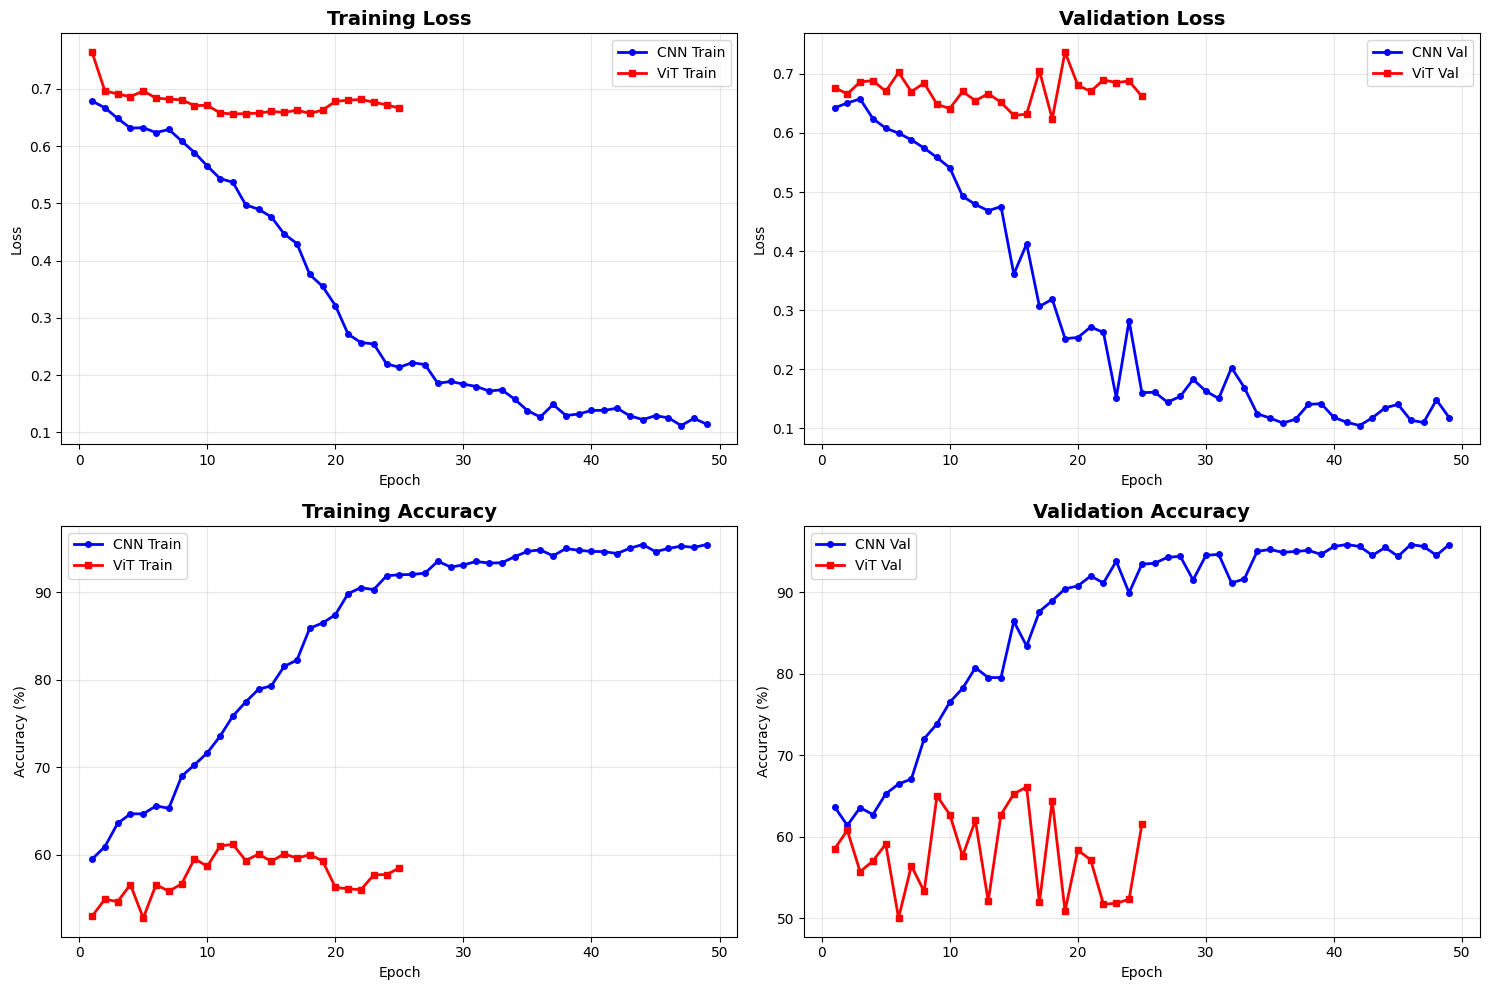

=== MODEL COMPARISON ===
CNN Best Validation Accuracy: 95.88%
ViT Best Validation Accuracy: 66.10%
Performance Difference: 29.78%
✅ CNN shows superior performance in forgery detection

📊 Training Statistics:
   CNN converged in 49 epochs
   ViT converged in 25 epochs


In [12]:
# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_cnn = range(1, len(cnn_train_losses) + 1)
epochs_vit = range(1, len(vit_train_losses) + 1)

# Training loss
ax1.plot(epochs_cnn, cnn_train_losses, 'b-o', label='CNN Train', linewidth=2, markersize=4)
ax1.plot(epochs_vit, vit_train_losses, 'r-s', label='ViT Train', linewidth=2, markersize=4)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation loss
ax2.plot(epochs_cnn, cnn_val_losses, 'b-o', label='CNN Val', linewidth=2, markersize=4)
ax2.plot(epochs_vit, vit_val_losses, 'r-s', label='ViT Val', linewidth=2, markersize=4)
ax2.set_title('Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Training accuracy
ax3.plot(epochs_cnn, cnn_train_accs, 'b-o', label='CNN Train', linewidth=2, markersize=4)
ax3.plot(epochs_vit, vit_train_accs, 'r-s', label='ViT Train', linewidth=2, markersize=4)
ax3.set_title('Training Accuracy', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Validation accuracy
ax4.plot(epochs_cnn, cnn_val_accs, 'b-o', label='CNN Val', linewidth=2, markersize=4)
ax4.plot(epochs_vit, vit_val_accs, 'r-s', label='ViT Val', linewidth=2, markersize=4)
ax4.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison
print("=== MODEL COMPARISON ===")
print(f"CNN Best Validation Accuracy: {max(cnn_val_accs):.2f}%")
print(f"ViT Best Validation Accuracy: {max(vit_val_accs):.2f}%")
print(f"Performance Difference: {abs(max(vit_val_accs) - max(cnn_val_accs)):.2f}%")

if max(vit_val_accs) > max(cnn_val_accs):
    print("✅ ViT shows superior performance in forgery detection")
else:
    print("✅ CNN shows superior performance in forgery detection")

print(f"\n📊 Training Statistics:")
print(f"   CNN converged in {len(cnn_val_accs)} epochs")
print(f"   ViT converged in {len(vit_val_accs)} epochs")